프로젝트 : 다양한 OCR모델 비교하기
======

Google OCR API, keras-ocr, Tesseract 3가지의 OCR 모델을 비교해 봅니다. 
     
1. 검증용 데이터셋 준비
2. Google OCR API, keras-ocr, Tesseract로 테스트 진행
3. 테스트 결과 정리
4. 결과 분석과 결론 제시
    
-21.12.02-

# 1. 검증용 데이터셋 준비

OCR 관련해서 오늘 다루어본 주제는 텍스트의 모양과 크기, 배치, 노이즈 등 OCR의 성능에 영향을 미치는 요인들에 관한 것이었습니다. 여러분들은 위 3가지 기능들이 이미지에 나타난 특징에 따라 얼마나 정확하게 문자를 detect하고 recognize하는지를 검증하기 위한 이미지 데이터를 모아야 합니다. 이미지가 많을수록 좋겠지만 검증해야 할 항목별로 고루 갖춰지는 것도 중요합니다.    

테스트용 이미지는 아무리 많아도 20장을 넘기지 않는 것으로 합니다. 

In [1]:
!ls ~/aiffel/Exploration/E18/data

covid-19.jpg		pytesseract_out  test1.png  test3.png  test5.png
my_google_api_key.json	tesseract	 test2.png  test4.png


# 2. Google OCR API, keras-ocr, Tesseract로 테스트 진행

위 3가지 모듈을 활용하는 방법에 대해서는 코드 레벨로 이미 경험해 보셨을 것입니다. 이미지 리스트를 정리한 후 반복문을 실행하며 모듈이 출력한 결과를 모아 봅시다.

In [2]:
# 입력 이미지 경로를 지정
import os

work_dir = os.getenv('HOME')+'/aiffel/Exploration/E18/data'
test1_path = work_dir + '/test2.png' 
test2_path = work_dir + '/test3.png'

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as img

In [4]:
# 이미지 출력 함수
def img_print(img_path, name='') : 
    image = img.imread(img_path) ## RGB 값
    plt.title(name)  ## 제목 
    plt.imshow(image) ## 이미지 출력
    plt.axis('off') ## 축 제거
    plt.show()

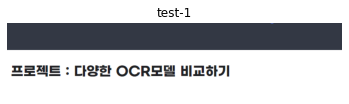

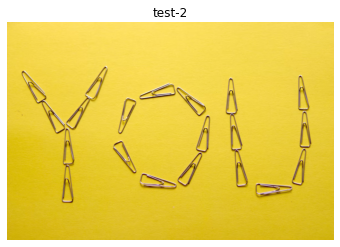

In [5]:
# test 이미지 출력 
img_print(test1_path, 'test-1')
img_print(test2_path, 'test-2')

## 2-1 Google OCR API

In [6]:
def detect_text_google(path):
    """Detects text in the file."""
    from google.cloud import vision
    import io
    client = vision.ImageAnnotatorClient()

    with io.open(path, 'rb') as image_file:
        content = image_file.read()
        
    image = vision.Image(content=content)

    response = client.text_detection(image=image)
    texts = response.text_annotations
    print('Texts:')
    
    for text in texts:
       print('\n"{}"'.format(text.description))

    vertices = (['({},{})'.format(vertex.x, vertex.y)
                 for vertex in text.bounding_poly.vertices])

    print('bounds: {}'.format(','.join(vertices)))

    if response.error.message:
        raise Exception(
            '{}\nFor more info on error messages, check: '
            'https://cloud.google.com/apis/design/errors'.format(
                response.error.message))
    return texts # description, bounding_poly 

In [7]:
# 로컬 환경에서는 다운받은 인증키 경로가 정확하게 지정되어 있어야 합니다. 
# 클라우드 환경에서는 무시해도 좋습니다
!ls -l $GOOGLE_APPLICATION_CREDENTIALS

os.environ["GOOGLE_APPLICATION_CREDENTIALS"] =  os.getenv('HOME')+'/aiffel/Exploration/E18/data/my_google_api_key.json'

total 1584
drwxr-xr-x 5 root root   4096 Dec  2 23:18 data
-rw-r--r-- 1 root root 729587 Dec  2 05:27 ocr_python.ipynb
-rw-r--r-- 1 root root 880959 Dec  3 00:01 ocr_test.ipynb


In [8]:
# 위에서 정의한 OCR API 이용 함수 호출
google_ocr = detect_text_google(test1_path)

Texts:

"프로젝트 : 다양한 OCR모델 비교하기
"

"프로젝트"

":"

"다양한"

"OCR"

"모델"

"비교"

"하기"
bounds: (428,91),(477,91),(477,114),(428,114)


In [9]:
google_ocr2 = detect_text_google(test2_path)

Texts:

"YOU
"

"YOU"
bounds: (24,160),(1119,168),(1115,687),(20,679)


- Google OCR API 는 한국어와 영어 둘다 모두 잘 인식하는 것을 볼 수 있다. 

In [45]:
def gg_crop(text, name):
    vertices = (['({},{})'.format(vertex.x, vertex.y)
                 for vertex in text[0].bounding_poly.vertices])
    
    left = vertices[0]
    top = vertices[1]
    width = vertices[2]
    height = vertices[3]

    #output_img_path = os.path.join(output_path, name+f"_{str(index).zfill(4)}.png")
    #print(output_img_path)
    cropped_image = image.crop((
        left,
        top,
        left+width,
        top+height
    ))
    
    cr_image = img.imread(cropped_image) ## RGB 값
    plt.title(name)  ## 제목 
    plt.imshow(cr_image) ## 이미지 출력
    plt.axis('off') ## 축 제거
    plt.show()
    
    print(text[0].description)
    #cropped_image.save(output_img_path)
    #cropped_image_path_list.append(output_img_path)
    
    return cropped_image_path_list

In [47]:
#gg_crop_path1 = gg_crop(google_ocr, 'test1')

## 2.2 keras-ocr

In [11]:
import keras_ocr

# keras-ocr이 detector과 recognizer를 위한 모델을 자동으로 다운로드받게 됩니다. 
pipeline = keras_ocr.pipeline.Pipeline()

Looking for /aiffel/.keras-ocr/craft_mlt_25k.h5
Looking for /aiffel/.keras-ocr/crnn_kurapan.h5


In [12]:
image_urls = [
    test1_path,
    test2_path
]

images = [ keras_ocr.tools.read(url) for url in image_urls]
prediction_groups = [pipeline.recognize([url]) for url in image_urls]

/opt/conda/lib/python3.7/site-packages/keras_ocr/tools.py:166: MatplotlibDeprecationWarning: The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  horizontalalignment='right' if side == 'left' else 'left')


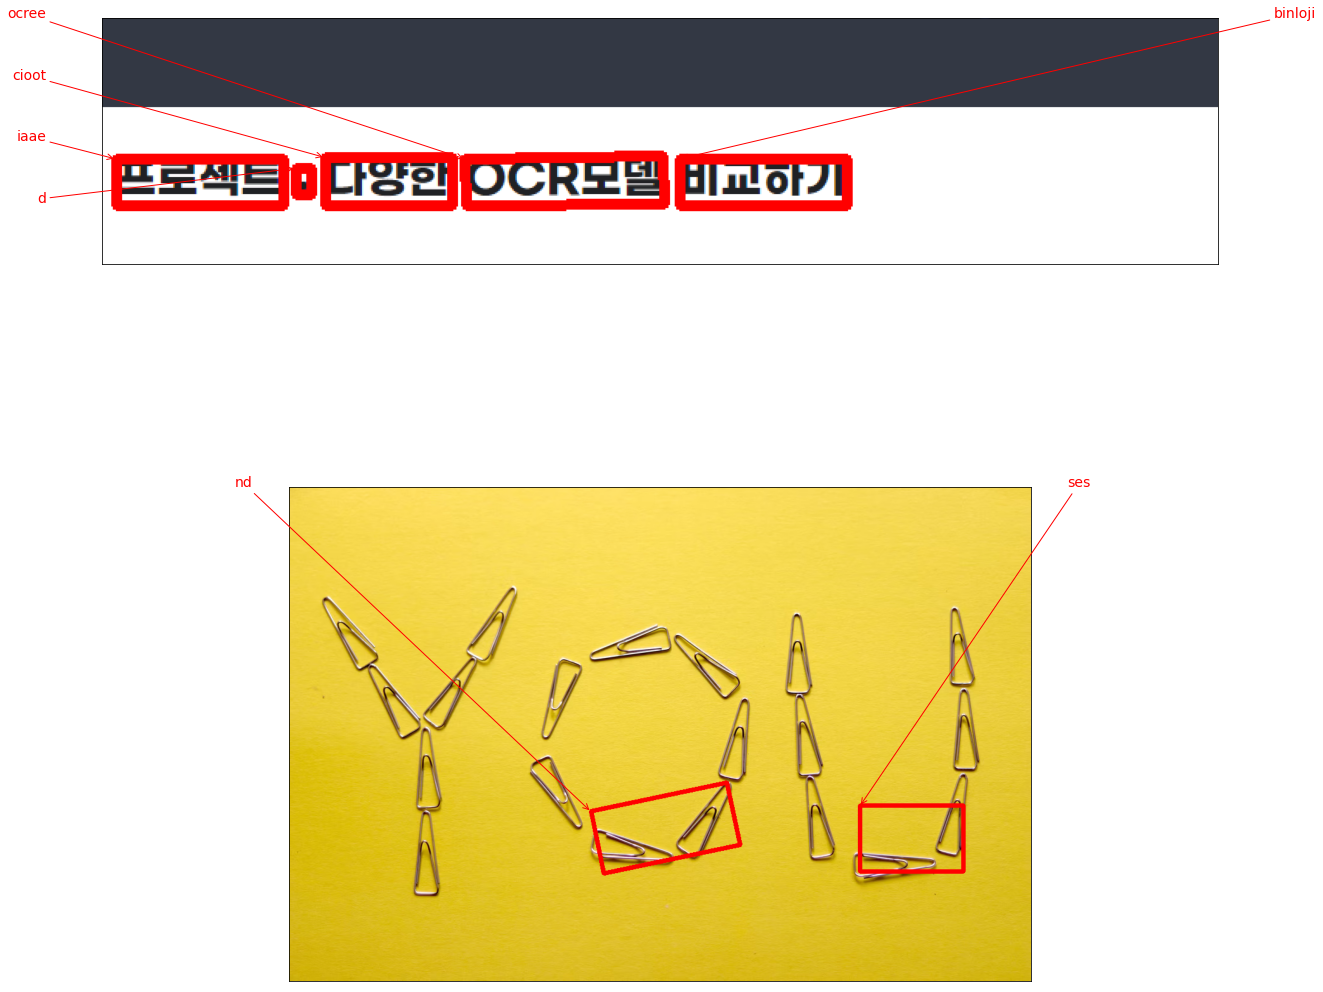

In [13]:
# Plot the predictions
fig, axs = plt.subplots(nrows=len(images), figsize=(20, 20))
for idx, ax in enumerate(axs):
    keras_ocr.tools.drawAnnotations(image=images[idx], 
                                    predictions=prediction_groups[idx][0], ax=ax)

- keras-ocr 모델은 영어만 인식하는 것을 볼 수 있다. 
- 하지만 test2 의 인식부분을 잘못 잡고있다. 

## 2.3 Tesseract

In [14]:
import pytesseract
from PIL import Image
from pytesseract import Output
import matplotlib.pyplot as plt

# OCR Engine modes(–oem):
# 0 - Legacy engine only.
# 1 - Neural nets LSTM engine only.
# 2 - Legacy + LSTM engines.
# 3 - Default, based on what is available.

# Page segmentation modes(–psm):
# 0 - Orientation and script detection (OSD) only.
# 1 - Automatic page segmentation with OSD.
# 2 - Automatic page segmentation, but no OSD, or OCR.
# 3 - Fully automatic page segmentation, but no OSD. (Default)
# 4 - Assume a single column of text of variable sizes.
# 5 - Assume a single uniform block of vertically aligned text.
# 6 - Assume a single uniform block of text.
# 7 - Treat the image as a single text line.
# 8 - Treat the image as a single word.
# 9 - Treat the image as a single word in a circle.
# 10 - Treat the image as a single character.
# 11 - Sparse text. Find as much text as possible in no particular order.
# 12 - Sparse text with OSD.
# 13 - Raw line. Treat the image as a single text line, bypassing hacks that are Tesseract-specific.

def crop_word_regions(image_path='./images/sample.png', output_path='./output',name=''):
    if not os.path.exists(output_path):
        os.mkdir(output_path)
    custom_oem_psm_config = r'--oem 3 --psm 3'
    image = Image.open(image_path)

    recognized_data = pytesseract.image_to_data(
        image, lang='eng',    # 한국어라면 lang='kor'
        config=custom_oem_psm_config,
        output_type=Output.DICT
    )
    
    top_level = max(recognized_data['level'])
    index = 0
    cropped_image_path_list = []
    for i in range(len(recognized_data['level'])):
        level = recognized_data['level'][i]
    
        if level == top_level:
            left = recognized_data['left'][i]
            top = recognized_data['top'][i]
            width = recognized_data['width'][i]
            height = recognized_data['height'][i]
            
            output_img_path = os.path.join(output_path, name+f"_{str(index).zfill(4)}.png")
            print(output_img_path)
            cropped_image = image.crop((
                left,
                top,
                left+width,
                top+height
            ))
            cropped_image.save(output_img_path)
            cropped_image_path_list.append(output_img_path)
            index += 1
    return cropped_image_path_list

In [20]:
cropped_image_path_list = crop_word_regions(test1_path, work_dir+'/tesseract', 'test1')
cropped_image_path_list2 = crop_word_regions(test2_path, work_dir+'/tesseract', 'test2')

/aiffel/aiffel/Exploration/E18/data/tesseract/test1_0000.png
/aiffel/aiffel/Exploration/E18/data/tesseract/test2_0000.png


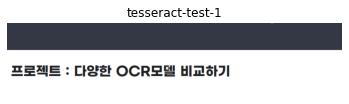

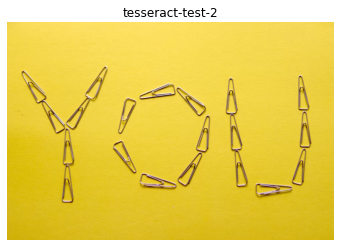

In [21]:
# test 이미지 출력 
for img_path in cropped_image_path_list : 
    img_print(img_path, 'tesseract-test-1')
    
for img_path in cropped_image_path_list2 : 
    img_print(img_path, 'tesseract-test-2')

In [22]:
from PIL import Image

# 단어 인식 
def recognize_images(cropped_image_path_list,lang):
    custom_oem_psm_config = r'--oem 3 --psm 7'
    
    for image_path in cropped_image_path_list:
        image = Image.open(image_path)
        recognized_data = pytesseract.image_to_string(
            image, lang=lang,    
            config=custom_oem_psm_config,
            output_type=Output.DICT
        )
        print(recognized_data['text'])
    print("----- Done ----- ")
    return recognized_data['text']

In [24]:
# 위에서 준비한 문자 영역 파일들을 인식하여 얻어진 텍스트를 출력합니다.
tesseract_eng = []
tesseract_eng.append(recognize_images(cropped_image_path_list,'eng')) # 영어
tesseract_eng.append(recognize_images(cropped_image_path_list2,'eng')) 

ZEWE : Sst OCRaS dlwotl

----- Done ----- 
1

----- Done ----- 


In [25]:
# 위에서 준비한 문자 영역 파일들을 인식하여 얻어진 텍스트를 출력합니다.
tesseract_kor = []
tesseract_kor.append(recognize_images(cropped_image_path_list, 'kor')) # 한국어
tesseract_kor.append(recognize_images(cropped_image_path_list2, 'kor'))

프로젝트 : 다양한 0ㅇ모델 비교하기

----- Done ----- 
0쁘

----- Done ----- 


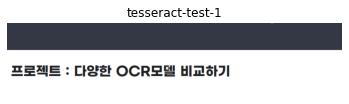

영어 인식 : 
ZEWE : Sst OCRaS dlwotl


한국어 인식 : 
프로젝트 : 다양한 0ㅇ모델 비교하기


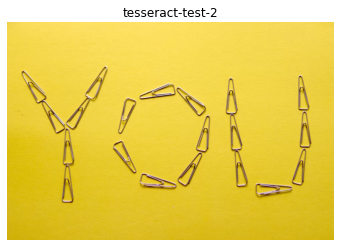

영어 인식 : 
1


한국어 인식 : 
0쁘


In [32]:
# 글자 인식부분과 인식한 글자 출력 
# test 이미지 출력 
for img_path in cropped_image_path_list : 
    img_print(img_path, 'tesseract-test-1')
    print('영어 인식 : ')
    print(tesseract_eng[0].split('\n\x0c')[0])
    print('\n')
    print('한국어 인식 : ')
    print(tesseract_kor[0].split('\n\x0c')[0])
    
for img_path in cropped_image_path_list2 : 
    img_print(img_path, 'tesseract-test-2')
    print('영어 인식 : ')
    print(tesseract_eng[1].split('\n\x0c')[0])
    print('\n')
    print('한국어 인식 : ')
    print(tesseract_kor[1].split('\n\x0c')[0])

- Tesseract 모델은 영어 또는 한국어 한가지만 인식할 수 있는 것을 볼 수 있다. 
- test2는 영어이지만 Tesseract 모델은 인식을 못하고 있다.

# 회고

1. OCR을 활용하여 구현하려는 서비스의 기획이 타당한가?
    - 문자 인식 서비스가 OCR를 적용 가능하며, OCR을 활용했을 때 더욱 유용해진다.
   
   
2. 모델 평가기준이 명확하고 체계적으로 세워졌는가?
    - 위의 테스트 결과로만 본다면, Google-ocr api > Tesseract > keras-ocr 순으로 성능이 좋은 것을 볼 수 있다. 
    - 평가 기준은 영어, 한국어 둘다 인식하는지와 글로 쓰여있지는 않지만 글자로 인식할 수 있는 이미지에 대하여 평가하였다. 
    
    
3. 평가기준에 따라 충분한 분량의 테스트가 진행되고 그 결과가 잘 정리되었는가?
    - 2장의 테스트 이미지를 사용해 제시된 평가 기준에 따른 테스트 결과가 정리되어 결론이 도출되었다.
